# Deep Fashion 2 product matching data generation

The purspose of this notebook is to prepare data ot be able to easily feed it into a siamese network for pattern matching training.

In [3]:
from collections import defaultdict
from dataclasses import dataclass

import json
import os
from typing import (
    List,
    Tuple
)
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from sklearn.model_selection import train_test_split

from data_loader import load_training_df

from visualization import display_instances

In [4]:
dataset_path = 'dataset'
output_dir = 'product_matching_dataset'
toy_output_dir = 'product_matching_dataset_toy'

os.makedirs(output_dir, exist_ok=True)
os.makedirs(toy_output_dir, exist_ok=True)

In [5]:
df = load_training_df(dataset_path)

## Generating training dataset

Get only relevant columns.

In [6]:
df = df[['bounding_box', 'category_id', 'category_name', 'pair_id', 'image_path']]

### Create supercategory map

Map images into supercategories to avoid having classes with low representation.

In [7]:
supercategory_map = {
    'short sleeve top': 'top',
    'long sleeve dress': 'dress',
    'trousers': 'trousers',
    'long sleeve top': 'top',
    'skirt': 'skirt',
    'shorts': 'shorts',
    'long sleeve outwear': 'outwear',
    'vest dress': 'dress',
    'short sleeve dress': 'dress',
    'vest': 'top',
    'sling dress': 'dress',
    'short sleeve outwear': 'outwear',
    'sling': 'top'
}

# Map category to supercategory
df.loc[:, 'supercategory_name'] = df.category_name.map(supercategory_map)

# Create id for supercategories
# Make sure ids start at 1
supercategory_id_map = {
    name: i + 1
    for i, name in enumerate(set(supercategory_map.values()))
}
df.loc[:, 'supercategory_id'] = df.supercategory_name.map(supercategory_id_map)

# Ensure no extra categories exist
assert set(supercategory_map.values()) == set(df.supercategory_name.unique())

In [8]:
df.sample(5)

,bounding_box,category_id,category_name,pair_id,image_path,supercategory_name,supercategory_id
id,,,,,,,
176233,"[178, 111, 345, 350]",10,short sleeve dress,13813,dataset/train/image/176233.jpg,dress,4
75039,"[23, 0, 558, 240]",1,short sleeve top,5928,dataset/train/image/075039.jpg,top,3
102218,"[221, 545, 452, 799]",7,shorts,8099,dataset/train/image/102218.jpg,shorts,5
137390,"[111, 160, 270, 395]",10,short sleeve dress,10821,dataset/train/image/137390.jpg,dress,4
14320,"[304, 560, 474, 761]",9,skirt,1151,dataset/train/image/014320.jpg,skirt,1


### Split between training, validation and test

In order to be able to measure how well the model generalizes, we will select non-overlapping pair ids for trianing, validation and testing.

In [9]:
all_pair_ids = df.pair_id.unique()
train_val_pair_ids, test_pair_ids = train_test_split(all_pair_ids,
                                                     test_size=0.125,
                                                     random_state=100)
train_pair_ids, val_pair_ids = train_test_split(train_val_pair_ids,
                                                test_size=0.125,
                                                random_state=250)

print(f'Number of pairs ids in training: {len(train_pair_ids)}')
print(f'Number of pairs ids in validation: {len(val_pair_ids)}')
print(f'Number of pairs ids in test: {len(test_pair_ids)}')

Number of pairs ids in training: 11143
Number of pairs ids in validation: 1592
Number of pairs ids in test: 1820


In [10]:
train_df = df[df.pair_id.isin(train_pair_ids)]
val_df = df[df.pair_id.isin(val_pair_ids)]
test_df = df[df.pair_id.isin(test_pair_ids)]

In [11]:
def abs_path_to_rel_path(path: str) -> str:
    return os.path.join('train', 'image', os.path.basename(path))


def build_dataset(instances: List[dict]) -> dict:
    """ Returns a dict-formatted dataset given a list of rows 
    
    The dictionary contains two main fields:
    
        - "category_to_pairs": Contains the list of available groups of
            product images indexed by category.
        - "pairs_to_data": Contains the individual instance data for each
            of the products in a "pair" indexed by category and then by pair id.
    
    """
    category_to_pair_ids = defaultdict(set)
    pair_id_to_data = defaultdict(lambda: defaultdict(list))

    for i, row in enumerate(instances):
        category_to_pair_ids[row['supercategory_name']] = \
            category_to_pair_ids[row['supercategory_name']].union({row['pair_id']})
        pair_id_to_data[row['supercategory_name']][row['pair_id']].append({
            'bounding_box': row['bounding_box'],
            'image_path': abs_path_to_rel_path(row['image_path'])
        })
    
    return {
        'category_to_pairs': category_to_pair_ids,
        'pairs_to_data': pair_id_to_data
    }

X_train = build_dataset(train_df.to_dict(orient='records'))
X_val = build_dataset(val_df.to_dict(orient='records'))
X_test = build_dataset(test_df.to_dict(orient='records'))

Serialize data.

In [12]:
def store_dataset(data: dict, dst_path: str) -> None:

    def serialize_sets(obj):
        if isinstance(obj, set):
            return list(obj)
        return obj

    with open(dst_path, 'w') as f:
        json.dump(data, f, default=serialize_sets)
        
store_dataset(X_train, os.path.join(output_dir, 'train.json'))
store_dataset(X_val, os.path.join(output_dir, 'validation.json'))
store_dataset(X_test, os.path.join(output_dir, 'test.json'))

## Generate toy dataset

This dataset will be used to check the training pipeline is able to learn and overfit a tiny dataset (will only be generating the training dataset).

In [13]:
pairs_subset = random.choices(df.pair_id.unique(), k=5)
toy_df = df[df.pair_id.isin(pairs_subset)]
X_toy = build_dataset(toy_df.to_dict(orient='records'))
store_dataset(X_toy, os.path.join(toy_output_dir, 'train.json'))

## Visualize pair data

Let's visualize data form all sets to get a grasp of what king of data we are dealing with.

In [14]:
with open(os.path.join(output_dir, 'train.json'), 'r') as f:
    train_data = json.load(f)

with open(os.path.join(output_dir, 'validation.json'), 'r') as f:
    val_data = json.load(f)

with open(os.path.join(output_dir, 'test.json'), 'r') as f:
    test_data = json.load(f)

NameError: name 'x2' is not defined

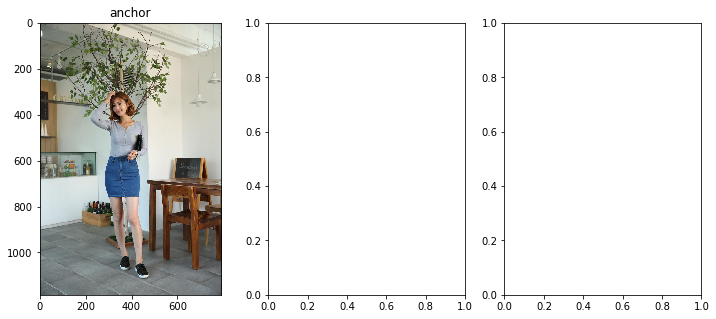

In [15]:
def visualize_triplet(category: str,
                      anchor: dict,
                      positive: dict,
                      negative: dict) -> None:
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    
    def _plot_example(example, ax, tag) -> None:
        ax.imshow(plt.imread(os.path.join('dataset', example['image_path'])))
        ax.set_title(tag)
        x1, y1, x2, y2 = example['bounding_box'] 
        rect = patches.Rectangle((x1, y1),
                                 x2 - x1, y2 - y1,
                                 linewidth=1,
                                 edgecolor='r',
                                 facecolor='none')
        ax.add_patch(rect)
    
    _plot_example(anchor, axs[0], 'anchor')    
    _plot_example(positive, axs[1], 'positive')    
    _plot_example(negative, axs[2], 'negative')
    fig.suptitle(f'Category: {category}')
    
def sample_triplet(category: str, data: dict) -> Tuple[dict, dict, dict]:
    anchor_id, negative_id = random.choices(
        data['category_to_pairs'][category],
        k=2
    )
    anchor, positive = random.choices(
        data['pairs_to_data'][category][str(anchor_id)],
        k=2
    )
    negative = random.sample(
        data['pairs_to_data'][category][str(negative_id)],
        1
    )[0]
    return anchor, positive, negative


def sample_category(data: dict) -> str:
    assert data['category_to_pairs'].keys() == data['pairs_to_data'].keys()
    return random.choice(list(data['category_to_pairs'].keys()))

category_sample = sample_category(train_data)
visualize_triplet(
    category_sample,
    *sample_triplet(category_sample, train_data)
)

In [ ]:
category_sample = sample_category(val_data)
visualize_triplet(
    category_sample,
    *sample_triplet(category_sample, val_data)
)

In [ ]:
category_sample = sample_category(test_data)
visualize_triplet(
    category_sample,
    *sample_triplet(category_sample, test_data)
)

## Future work

- Use segmentation mask instead of bounding box. By doing so, we will prevent overfitting the background.